# Prédiction de la note des vins

Le notebook compare plusieurs de modèles de régression.

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
from papierstat.datasets import load_wines_dataset
df = load_wines_dataset()
X = df.drop(['quality', 'color'], axis=1)
y = yn = df['quality']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

On normalise les données.

In [5]:
from sklearn.preprocessing import normalize
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)
X_norm = normalize(X)

Cette façon de faire est complètement erronnée car il est peu probable que la même normalisation soit apppliquée sur les trois bases. La normalisation doit être estimée sur la base d'apprentissage et appliquée sur la base de test. Reprenons.

In [6]:
from sklearn.preprocessing import Normalizer
norm = Normalizer()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)
X_norm = norm.transform(X)

On récupère beaucoup de modèles implémentés dans *scikit-learn* pour la régression.

In [7]:
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from sklearn.neural_network import *

models = [
    model for name, model in globals().items() if (
        hasattr(model, 'fit') and not hasattr(model, 'predict_proba') and
        hasattr(model, '__name__') and not model.__name__.endswith('CV') and
        'Logistic' not in model.__name__ and 'Regr' in model.__name__)]

import pprint
pprint.pprint(models)

[<class 'sklearn.linear_model._bayes.ARDRegression'>,
 <class 'sklearn.linear_model._huber.HuberRegressor'>,
 <class 'sklearn.linear_model._base.LinearRegression'>,
 <class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveRegressor'>,
 <class 'sklearn.linear_model._quantile.QuantileRegressor'>,
 <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>,
 <class 'sklearn.linear_model._theil_sen.TheilSenRegressor'>,
 <class 'sklearn.linear_model._ransac.RANSACRegressor'>,
 <class 'sklearn.linear_model._glm.glm.PoissonRegressor'>,
 <class 'sklearn.linear_model._glm.glm.GammaRegressor'>,
 <class 'sklearn.linear_model._glm.glm.TweedieRegressor'>,
 <class 'sklearn.ensemble._forest.RandomForestRegressor'>,
 <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>,
 <class 'sklearn.ensemble._bagging.BaggingRegressor'>,
 <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>,
 <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>,
 <class 'sklearn.ensemble._voting.Votin

In [8]:
from sklearn.metrics import r2_score

def score_model(xtr, xte, ytr, yte, model):
    try:
        model.fit(xtr, ytr)
    except Exception as e:
        raise Exception("Issue with model '{0}'".format(model.__name__)) from e
    return r2_score(yte, model.predict(xte))

In [9]:
from time import perf_counter 
r2s = []
names = []
durations = []
regressors = {}
for i, model in enumerate(models):
    if model.__name__ in {'ARDRegression', 'VotingRegressor', 'StackingRegressor',
                          'QuantileRegressor'}:
        continue
    try:
        reg = model()
    except Exception as e:
        print('Skip', model)
        continue
    begin = perf_counter()
    r2 = score_model(X_train_norm, X_test_norm, y_train, y_test, reg)
    duree = perf_counter () - begin
    r2s.append(r2)
    names.append(model.__name__)
    durations.append(duree)
    regressors[model.__name__] = reg
    print(i, model.__name__, r2, duree)

1 HuberRegressor 0.18696322297535295 0.10263620000000007
2 LinearRegression 0.18670706392432423 0.0031078999999998302
3 PassiveAggressiveRegressor -2.4493503320572922 0.00904460000000018
5 SGDRegressor 0.014418866580130474 0.005636599999999881
6 TheilSenRegressor -0.22921086116095046 2.5755812999999996
7 RANSACRegressor -0.22456172730313217 0.10757049999999957
8 PoissonRegressor 0.0019476060926755245 0.008242899999999942
9 GammaRegressor 0.00035190831663889366 0.0046112000000002595
10 TweedieRegressor 0.00035356971012889815 0.00390669999999993
11 RandomForestRegressor 0.4902308886152582 3.781266499999999
12 ExtraTreesRegressor 0.5234939074444616 1.2828908000000006
13 BaggingRegressor 0.4275524601097942 0.3720353999999997
14 GradientBoostingRegressor 0.33578249602447263 2.3406590000000005
15 AdaBoostRegressor 0.19852494764300066 0.5364822
18 HistGradientBoostingRegressor 0.4116613218417975 1.8669652999999986
19 KNeighborsRegressor 0.17441896259812206 0.06659600000000054
20 RadiusNeighbo

In [10]:
import pandas
df = pandas.DataFrame(dict(model=names, r2=r2s, duree=durations))
df = df[['model', 'r2', 'duree']]
df.sort_values('r2')

,model,r2,duree
2,PassiveAggressiveRegressor,-2.449350,0.009045
4,TheilSenRegressor,-0.229211,2.575581
5,RANSACRegressor,-0.224562,0.107570
16,RadiusNeighborsRegressor,0.000121,0.738143
7,GammaRegressor,0.000352,0.004611
8,TweedieRegressor,0.000354,0.003907
6,PoissonRegressor,0.001948,0.008243
3,SGDRegressor,0.014419,0.005637
15,KNeighborsRegressor,0.174419,0.066596
17,MLPRegressor,0.181477,4.301111


On filtre les valeurs inférieures à -1.

In [11]:
df = df[df.r2 >= -1]

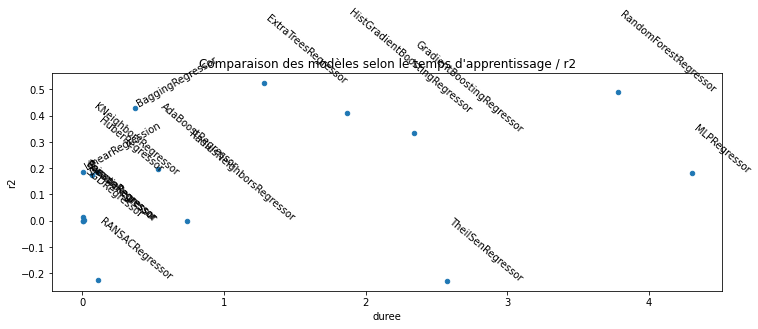

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
df.plot(x='duree', y='r2', kind="scatter", ax=ax)
for row in df.itertuples():
    t, y, x = row[1:4]
    if t[0] in {'B', 'L'}:
        ax.text(x, y, t, rotation=30, ha='left', va='bottom')
    else:
        ax.text(x, y, t, rotation=-40)
ax.set_title("Comparaison des modèles selon le temps d'apprentissage / r2");

L'estimateur [RANSACRegressor](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py) produit un $R^2$ très négatif. Regardons plus en détail.

In [13]:
pred = regressors['RANSACRegressor'].predict(X_test_norm)

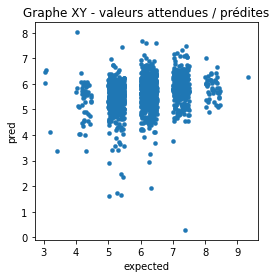

In [14]:
import numpy.random
df = pandas.DataFrame(dict(pred=pred, expected=y_test))
df['expected'] += numpy.random.random(df.shape[0]) * 0.5
ax = df.plot(x="expected", y="pred", kind='scatter', figsize=(4, 4), linewidths=0.1)
ax.set_title('Graphe XY - valeurs attendues / prédites');

Essayons de voir avec la densité.

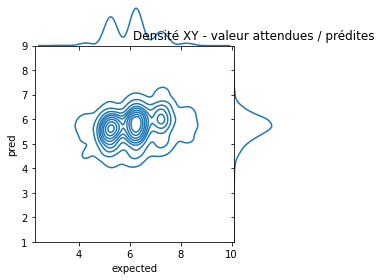

In [15]:
import seaborn
ax = seaborn.jointplot(df["expected"], df["pred"], kind="kde", size=4, space=0, ylim=(1, 9))
ax.ax_marg_y.set_title('Densité XY - valeur attendues / prédites');

Pas facile à voir. Essayons de voir autrement en triant les prédictions et les valeurs attendues par ordre.

In [16]:
sv = df.sort_values(['expected', 'pred']).reset_index(drop=True)

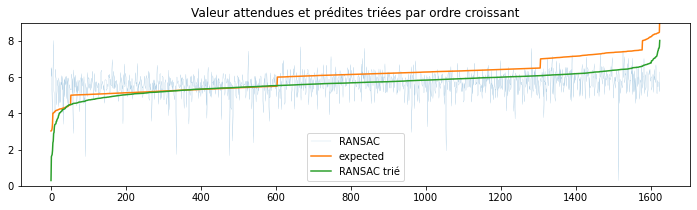

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(sv["pred"], label="RANSAC", lw=0.1)
ax.plot(list(sorted(df["expected"])), label="expected")
ax.plot(list(sorted(df["pred"])), label="RANSAC trié")
ax.set_ylim([0, 9])
ax.set_title('Valeur attendues et prédites triées par ordre croissant')
ax.legend();

Le modèle est plutôt agité.

In [18]:
regressors['RANSACRegressor'].estimator_.intercept_

8.296147714878684

Pour s'assurer que les résultats sont fiables, il faut recommencer avec une validation croisée.

In [19]:
import numpy.random
rnd = numpy.random.permutation(range(X_norm.shape[0]))
xns = X_norm[rnd, :]
yns = yn[rnd]
xns.shape, yns.shape

((6497, 11), (6497,))

In [20]:
from sklearn.model_selection import cross_val_score

def score_model_cross(xn, yn, model):
    res = cross_val_score(model, xn, yn, cv=5)
    return res.mean(), min(res), max(res)

score_model_cross(xns, yns, LinearRegression())

(0.17975891799937466, 0.16696505316283117, 0.19857004070455042)

In [21]:
r2s = []
mis = []
mas = []
names = []
durations = []
regressors = {}
for i, model in enumerate(models):
    if model.__name__ in {'ARDRegression', 'VotingRegressor', 'QuantileRegressor'}:
        continue
    try:
        reg = model()
    except Exception as e:
        print('Skip', model)
        continue
    begin = perf_counter()
    r2, mi, ma = score_model_cross(xns, yns, reg)
    duree = perf_counter() - begin
    r2s.append(r2)
    mis.append(mi)
    mas.append(ma)
    names.append(model.__name__)
    durations.append(duree)
    regressors[model.__name__] = reg
    print(i, model.__name__, r2, mi, ma, "t=%r" % duree)

1 HuberRegressor 0.15926614746076234 0.14654481316725898 0.16913851017974213 t=0.454639499999999
2 LinearRegression 0.17975891799937466 0.16696505316283117 0.19857004070455042 t=0.016710999999997256
3 PassiveAggressiveRegressor -1.2023166987836942 -3.9867877266892178 0.1473069141592367 t=0.060205800000002085
5 SGDRegressor 0.008672768127243647 0.0021660038805777493 0.019095545791309232 t=0.03673420000000149
6 TheilSenRegressor -0.36938713022242337 -0.6323773846900367 -0.1285090090856622 t=12.1253441
7 RANSACRegressor -1.216541764611399 -2.1838034440150125 -0.49602375704620316 t=0.4227926000000011
8 PoissonRegressor 0.0005335331789835696 -0.00324272848486995 0.002202890520605516 t=0.041724600000002
9 GammaRegressor -0.0011833153140562436 -0.005003239249327773 0.00038081596763739345 t=0.03832559999999319
10 TweedieRegressor -0.0011890320765876484 -0.005037356583908137 0.0003836189724416572 t=0.03498609999999758
11 RandomForestRegressor 0.49573724359207744 0.47719555839567485 0.5195191337

In [22]:
df = pandas.DataFrame(dict(model=names, r2=r2s, min=mis, max=mas, duree=durations))
df = df[['model', 'r2', 'min', 'max', 'duree']]
df.sort_values('r2')

,model,r2,min,max,duree
5,RANSACRegressor,-1.216542,-2.183803,-0.496024,0.422793
2,PassiveAggressiveRegressor,-1.202317,-3.986788,0.147307,0.060206
4,TheilSenRegressor,-0.369387,-0.632377,-0.128509,12.125344
16,RadiusNeighborsRegressor,-0.001493,-0.005366,0.000122,3.920080
8,TweedieRegressor,-0.001189,-0.005037,0.000384,0.034986
7,GammaRegressor,-0.001183,-0.005003,0.000381,0.038326
6,PoissonRegressor,0.000534,-0.003243,0.002203,0.041725
3,SGDRegressor,0.008673,0.002166,0.019096,0.036734
0,HuberRegressor,0.159266,0.146545,0.169139,0.454639
1,LinearRegression,0.179759,0.166965,0.198570,0.016711


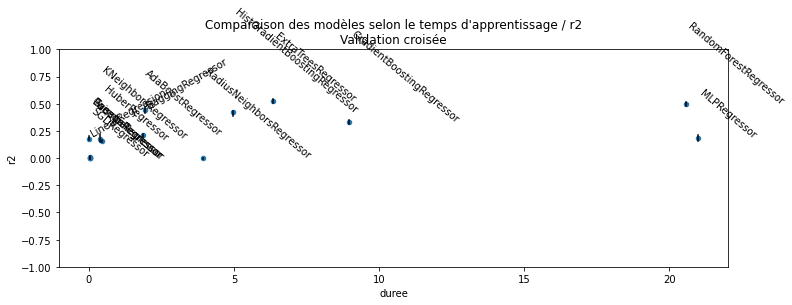

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
df[df['min'] > -0.1].plot(x='duree', y='r2', kind="scatter", ax=ax)
for row in df.itertuples():
    t, y, mi, ma, x = row[1:6]
    if mi < -0.1:
        continue
    ax.plot([x, x], [mi, ma], color="black")
    if t[0] in {'B', 'L'}:
        ax.text(x, y, t, rotation=30, ha='left', va='bottom')
    else:
        ax.text(x, y, t, rotation=-40)
ax.set_ylim([-1, 1])
ax.set_title("Comparaison des modèles selon le temps d'apprentissage / r2\nValidation croisée");

Le modèle [RANSAC](http://scikit-learn.org/stable/modules/linear_model.html#ransac-random-sample-consensus) est conçu pour apprendre un modèle linéaire et réduire l'ensemble d'apprentissage aux points non aberrants. Dans notre cas, vu le peu d'exemples pour les notes élevées, il est très probable que celles-ci disparaissent des observations choisies pour estimer le modèle : le modèle choisit d'évincer les exemples pour lesquels l'erreur est la plus grande en considérant que cela est une indication du fait qu'ils sont aberrants. Malgré cela, sa faible capacité à prévoir vient du fait que la majorité des vins ont une note entre 4 et 6 et que finalement, il y a peu de différences : ils sont tous moyens et la différence s'explique par d'autres facteurs comme le juge ayant donné la note.